In [4]:
from monolayer_tracking.segmented_comprehension import TimeSeries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy import ndimage
from skimage import io

In [2]:
stack=TimeSeries(r"Z:\Heather\NORI_data\24-07-18 MDCK time lapse QPM with Heather\segmented\region4")

In [10]:
QPM_data=io.imread(r"Y:\Heather\24-07-18 MDCK time lapse QPM with Heather\composite\colony_region4.tif")[...,3]
for frame, QPM in zip(tqdm(stack.frames), QPM_data):
    frame.QPM=QPM

  0%|          | 0/49 [00:00<?, ?it/s]

In [11]:
for frame in tqdm(stack.frames):
    masses=ndimage.sum(frame.QPM, frame.masks, index=np.arange(1, frame.n+1))
    for cell, mass in zip(frame.cells, masses):
        cell.QPM_mass=mass

  0%|          | 0/49 [00:00<?, ?it/s]

In [23]:
# FUCCI measurement
for frame in stack.frames:
    frame.FUCCI=frame.img[...,0], frame.img[...,1]
    frame.measure_FUCCI(orange_brightness=1)

In [12]:
import trackpy as tp

stack.track_centroids(memory=0)
t=tp.filter_stubs(stack.tracked_centroids, 20)
long_tracks=t.particle.unique()

In [13]:
masses=[]
areas=[]
for cell_ID in long_tracks:
    particle=stack.get_particle(cell_ID)
    cell_mass=[]
    cell_area=[]
    for cell_frame in particle:
        cell_mass.append(cell_frame.QPM_mass)
        cell_area.append(cell_frame.get_area())
    masses.append(cell_mass)
    areas.append(cell_area)

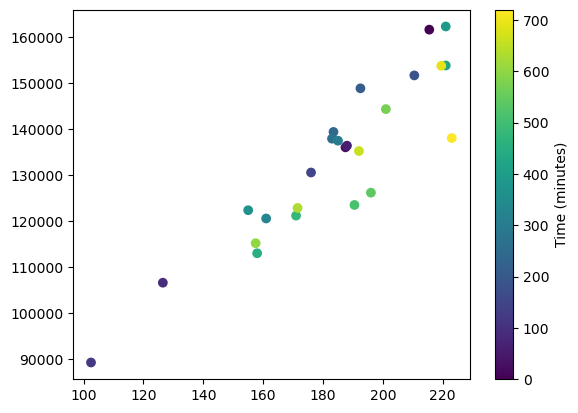

In [14]:
n=3
plt.scatter(areas[n], masses[n], c=np.arange(len(areas[n]))*30, cmap='viridis')
plt.colorbar(label='Time (minutes)')

(array([70., 84., 29., 13., 12.,  9., 11.,  3.,  5.,  1.]),
 array([0.01843967, 0.04596992, 0.07350018, 0.10103043, 0.12856068,
        0.15609093, 0.18362119, 0.21115144, 0.23868169, 0.26621194,
        0.2937422 ]),
 <BarContainer object of 10 artists>)

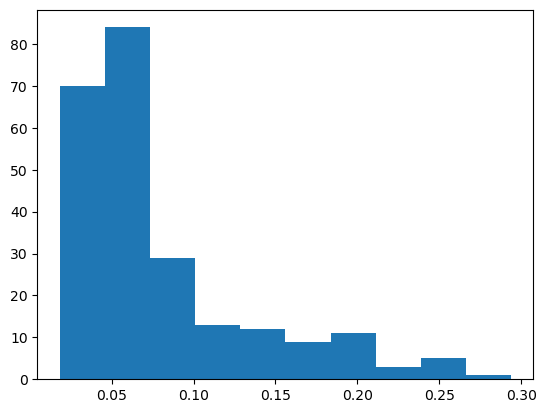

In [15]:
cell_stds=ndimage.standard_deviation(frame.QPM, frame.masks, index=np.arange(1, frame.n+1))
cell_means=ndimage.mean(frame.QPM, frame.masks, index=np.arange(1, frame.n+1))

cell_CVs=cell_stds/cell_means

plt.hist(cell_CVs)

In [16]:
def plot_cell_attribute(frame, attribute, cmap='viridis', ax=None, alpha=1, cax=None, vmin=None, vmax=None, **kwargs):
    if not ax: ax=plt.gca()
    if not cax:
        cax=ax.inset_axes([1.05, 0, 0.05, 1])
    values=np.array(frame.get_cell_attr(attribute))
    cmap_range=[values.min(), values.max()]
    if vmin is not None:
        cmap_range[0]=vmin
    if vmax is not None:
        cmap_range[1]=vmax

    num_labels=frame.masks.max() # number of unique labels (including background)
    cell_colors=plt.get_cmap(cmap)((values-cmap_range[0])/(cmap_range[1]-cmap_range[0]))
    cell_colors[...,3]=alpha
    color_map=np.insert(cell_colors, 0, [0,0,0,0], axis=0)

    mask_overlay=color_map[frame.masks]
    mask_overlay[frame.outlines]=[0,0,0,1] # black outlines
    ax.imshow(mask_overlay)
        
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(*cmap_range)), cax=cax, label=attribute)
    return mask_overlay, color_map

In [237]:
from monolayer_tracking import preprocessing
for frame in tqdm(stack.frames):
    fig, axes=plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(preprocessing.normalize(frame.img))
    axes[1].imshow(frame.QPM, cmap='gray')
    mask_overlay, color_map=plot_cell_attribute(frame, 'QPM_mass', alpha=0.4, cmap='inferno', ax=axes[1], vmin=51763.99, vmax=271405.31)

    fig.tight_layout()
    plt.savefig(f'C:/Users/Andy/Desktop/QPM/segmented_{frame.frame_number}.jpg', dpi=300)
    plt.close()

  0%|          | 0/49 [00:00<?, ?it/s]

In [17]:
all_QPM_masses=[]
for frame in tqdm(stack.frames):
    all_QPM_masses.append(frame.get_cell_attr('QPM_mass'))

  0%|          | 0/49 [00:00<?, ?it/s]

Text(0, 0.5, 'QPM Mass (no units)')

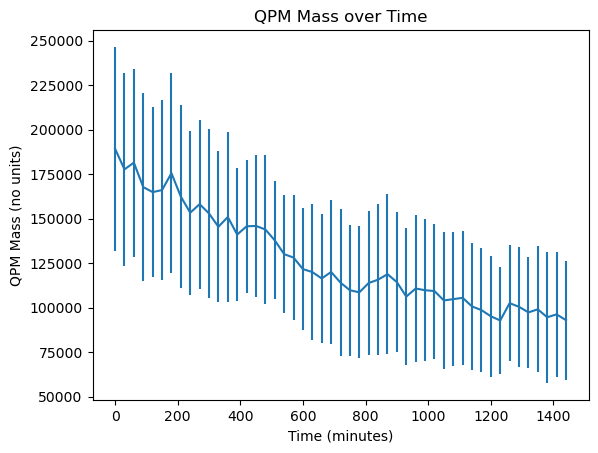

In [18]:
plt.errorbar(np.arange(len(all_QPM_masses))*30, [np.mean(masses) for masses in all_QPM_masses], yerr=[np.std(masses) for masses in all_QPM_masses])

plt.title('QPM Mass over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('QPM Mass (no units)')